In [1]:
import numpy as np
from scipy.misc import imread, imresize, imshow
import matplotlib.pyplot as plt
import glob, os, cv2, heapq
from sklearn import cross_validation, datasets, svm, cluster


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [22]:
# Constant parameters
MAX_SIFT = 70
NUM_BINS = 30

In [15]:
#Load the data from CAL-TECH 101 dataset
data = []
labels = []
categories = ['crab', 'trilobite', 'ewer']
for idx, cat in enumerate(categories):
    path = '101_ObjectCategories/%s/*.jpg'%(cat)
    for filename in glob.glob(path): #assuming jpg
        im=imread(filename)
        data.append(im)
        labels.append(idx)
labels = np.asarray(labels)

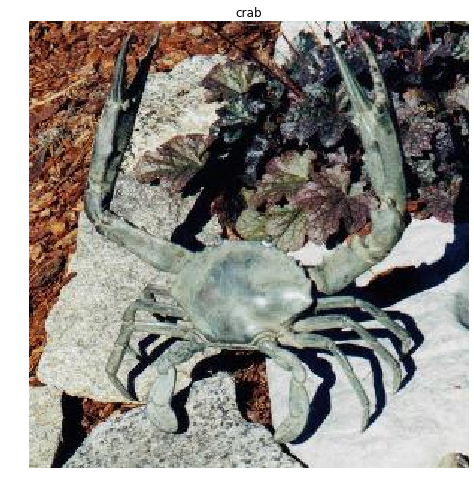

In [16]:
#Visualize an Image 
plt.imshow(data[0])
plt.axis('off')
plt.title('crab')
plt.show()

In [26]:
#Calculate the SIFT features of the data
def sift_words (data):
    sift = cv2.SIFT()
    words = []
    for ind, d in enumerate(data):
        if len(d.shape) == 2:
            gray = d[:]
        else:
            gray= cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)
        

        kp, des = sift.detectAndCompute(gray, None)
        response = np.zeros(len(kp))
        for index, value in enumerate(kp):
            response[index] = value.response
        temp = heapq.nlargest(MAX_SIFT, range(len(response)), response.take)
        words.append(des[temp, :])
    return words
        
words = sift_words(data)

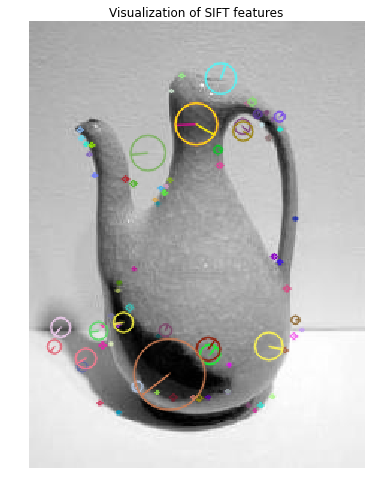

In [27]:
#Visualize one SIFT feature Image
sift = cv2.SIFT()
gray= cv2.cvtColor(data[180], cv2.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(gray, None)
img=cv2.drawKeypoints(gray,kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.axis('off')
plt.title('Visualization of SIFT features')
plt.show()


In [30]:
#K-Means Clustering
all_words = np.zeros((len(words)*MAX_SIFT, words[0].shape[1]))
for idx, val in enumerate(words):
    all_words[idx*MAX_SIFT:(idx+1)*MAX_SIFT, :] = val

k_means = cluster.KMeans(n_clusters = NUM_BINS, max_iter=3000, random_state = 0)
k_means.fit(all_words)

KMeans(copy_x=True, init='k-means++', max_iter=3000, n_clusters=30, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=0, tol=0.0001,
    verbose=0)

In [31]:
# Final features in of length NUM_BINS
dictionary = np.zeros((len(data), k_means.n_clusters))

for idx in range(len(words)):
    temp = k_means.labels_[idx*MAX_SIFT:(idx+1)*MAX_SIFT]
    #Calcualte the histogram and divide by MAX_SIFT features length to normalize
    hist = np.histogram(temp, bins = k_means.n_clusters, density = False)[0]/float(MAX_SIFT)
    dictionary[idx, :] = hist 
#     dictionary.append()

print (dictionary.shape)

(244, 30)


In [40]:
#Classification using SVM 
from sklearn import grid_search

gammas = np.logspace(-6, -1, 10)
C = np.array([0.5, 1, 2, 4, 8, 10, 15, 20, 50, 100, 200, 375, 500, 1000])
svc = svm.SVC(decision_function_shape='ovr')

clf = grid_search.GridSearchCV(estimator=svc, param_grid=dict(gamma = gammas, C = C),
                   n_jobs=-1)


X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    dictionary, labels, test_size = 0.2, random_state = 0)

clf = clf.fit(dictionary,labels)

print 'The best accuracy:', clf.best_score_  

print 'The best value of gamma:', clf.best_estimator_.gamma

print 'The best value of C:', clf.best_estimator_.C

# print 'Final accuracy:', clf.score(X_test, y_test)

The best accuracy: 0.590163934426
The best value of gamma: 0.1
The best value of C: 200.0


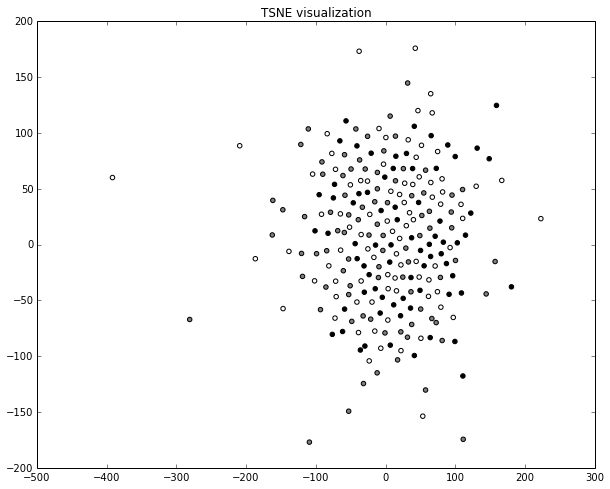

In [36]:
#sklearn Tsne visualization
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
low_embedding = model.fit_transform(dictionary) 

plt.scatter(low_embedding[:, 0], low_embedding[:, 1], c=labels)
plt.title("TSNE visualization")